# Modelo Long Short Term Memory
Autor: Kevin Cristopher J. Alvarado Maldonado

Email: kcjalvarado@gmail.com

In [468]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

### Carga de datos

In [469]:
df = pd.read_csv("datainflacion.csv")

In [470]:
inflacionInteranual = df[["Periodo","inf_gt_interanual"]]

### Data a utilizar

In [471]:
inflacionInteranual

,Periodo,inf_gt_interanual
0,01/01/2005,0.0904
1,01/02/2005,0.0904
2,01/03/2005,0.0877
3,01/04/2005,0.0888
4,01/05/2005,0.0852
...,...,...
204,01/01/2022,0.0287
205,01/02/2022,0.0298
206,01/03/2022,0.0417
207,01/04/2022,0.0462


Valores agregados para obtener pronosticos finales

In [472]:
inflacionInteranual = inflacionInteranual.append({'Periodo':'01/06/2022','inf_gt_interanual':0.0755}, ignore_index=True)
inflacionInteranual = inflacionInteranual.append({'Periodo':'01/07/2022','inf_gt_interanual':0.0836}, ignore_index=True)
inflacionInteranual = inflacionInteranual.append({'Periodo':'01/08/2022','inf_gt_interanual':0}, ignore_index=True)


In [473]:
inflacionInteranual.index = pd.to_datetime(inflacionInteranual['Periodo'],format='%d/%m/%Y')

In [475]:
temp = inflacionInteranual['inf_gt_interanual']

<AxesSubplot:xlabel='Periodo'>

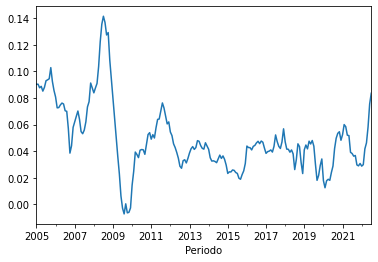

In [476]:
temp.plot()

### Manipulacion de los datos para formar el tensor

In [477]:
def df_to_X_y(df, window_size=5):
    #Esta funcion crea el tensor a ser procesado
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)

    return np.array(X), np.array(y)


In [478]:
window_size = 5
X, y = df_to_X_y(temp, window_size)

### Area de calibracion de parametros
Seleccion entre muestras de entreno, valuacion y prueba

In [479]:
X_train, y_train = X[:140],y[:140]
X_val, y_val = X[140:180], y[140:180]
X_test, y_test = X[180:], y[180:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140, 5, 1), (140,), (40, 5, 1), (40,), (26, 5, 1), (26,))

Tensorflow para el modelo LSTM

In [480]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

Instacia del modelo a utilizar

In [481]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

In [482]:
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                16896     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


### Model Checkpoint
Permite guardar el mejor modelo resultado 

In [483]:
cp = ModelCheckpoint('model1/',save_best_only=True)

### Adam
La optimización de Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de momentos de primer y segundo orden.

Según Kingma et al., 2014, el método es "computacionalmente eficiente, requiere poca memoria, es invariable al cambio de escala diagonal de gradientes y es adecuado para problemas que son grandes en términos de datos/parámetros".

Nos apoya a establecer la tasa de aprendimiento.

### RMSE
Se utiliza para comparar entre los modelos para determinar el que presenta el mejor ajuste

In [484]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])

Ajuste del modelo

In [485]:
model1.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
1/5 [=====>........................] - ETA: 8s - loss: 0.0031 - root_mean_squared_error: 0.0559

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 6s 1s/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 1.6878e-04 - val_root_mean_squared_error: 0.0130
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 5.9483e-04 - root_mean_squared_error: 0.0244 - val_loss: 5.2178e-04 - val_root_mean_squared_error: 0.0228
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 4.9683e-04 - root_mean_squared_error: 0.0223

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 4s 933ms/step - loss: 3.8752e-04 - root_mean_squared_error: 0.0197 - val_loss: 8.1249e-05 - val_root_mean_squared_error: 0.0090
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 3.4380e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 4s 979ms/step - loss: 3.2678e-04 - root_mean_squared_error: 0.0181 - val_loss: 6.9389e-05 - val_root_mean_squared_error: 0.0083
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 2.8805e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.8889e-04 - val_root_mean_squared_error: 0.0197
Epoch 6/10
5/5 [==============================] - 0s 27ms/step - loss: 3.6507e-04 - root_mean_squared_error: 0.0191 - val_loss: 8.4825e-05 - val_root_mean_squared_error: 0.0092
Epoch 7/10
1/5 [=====>........................] - ETA: 0s - loss: 3.7258e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 4s 994ms/step - loss: 3.2292e-04 - root_mean_squared_error: 0.0180 - val_loss: 6.5833e-05 - val_root_mean_squared_error: 0.0081
Epoch 8/10
5/5 [==============================] - 0s 18ms/step - loss: 2.5835e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.1645e-04 - val_root_mean_squared_error: 0.0178
Epoch 9/10
5/5 [==============================] - 0s 18ms/step - loss: 3.4059e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.3876e-04 - val_root_mean_squared_error: 0.0118
Epoch 10/10
5/5 [==============================] - 0s 14ms/step - loss: 2.4114e-04 - root_mean_squared_error: 0.0155 - val_loss: 3.0623e-04 - val_root_mean_squared_error: 0.0175


Luego del ajuste se toma el mejor de todos los modelos presentados en la calibracion

In [486]:
best_model = load_model('model1/')

Se obtinen las predicciones utilizando el mejor modelo

In [487]:
train_predictions = best_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train_Predictions':train_predictions,'Valores_Reales':y_train})

5/5 [==============================] - 0s 2ms/step


In [488]:
train_results

,Train_Predictions,Valores_Reales
0,0.077049,0.0880
1,0.076799,0.0930
2,0.077829,0.0937
3,0.079134,0.0945
4,0.080323,0.1029
...,...,...
135,0.040737,0.0456
136,0.041244,0.0476
137,0.041871,0.0467
138,0.042117,0.0423


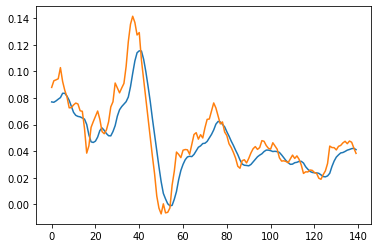

In [489]:
plt.plot(train_results['Train_Predictions'])
plt.plot(train_results['Valores_Reales'])

In [490]:
val_predictions =  model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val_Predictions':val_predictions, 'Actuals':y_val})

2/2 [==============================] - 0s 3ms/step


In [491]:
val_results

,Val_Predictions,Actuals
0,0.056375,0.0396
1,0.055223,0.0400
2,0.054339,0.0409
3,0.053998,0.0393
4,0.053645,0.0436
5,0.054729,0.0522
6,0.057740,0.0472
7,0.058837,0.0436
8,0.058633,0.0420
9,0.058067,0.0469


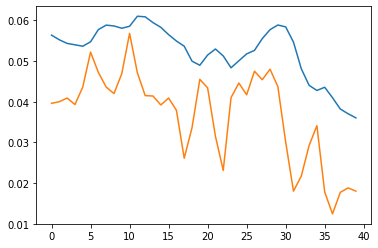

In [492]:
plt.plot(val_results['Val_Predictions'])
plt.plot(val_results['Actuals'])

In [493]:
test_predictions =  model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test_Predictions':test_predictions, 'Actuals':y_test})
test_results

1/1 [==============================] - 0s 22ms/step


,Test_Predictions,Actuals
0,0.034829,0.0239
1,0.036526,0.0288
2,0.039490,0.0419
3,0.044850,0.0497
4,0.051049,0.0534
5,0.056880,0.0546
6,0.061250,0.0482
7,0.062539,0.0524
8,0.063609,0.0600
9,0.065890,0.0584


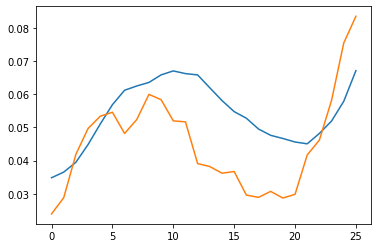

In [494]:
plt.plot(test_results['Test_Predictions'])
plt.plot(test_results['Actuals'])

## RMSE para el modelo LSTM

In [497]:
best_model.loss(test_results.Test_Predictions,test_results.Actuals)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0002135633940713716>

### El valor para el RMSE es de 0.0002135

### Para poner en contexto cuantas veces es mas eficiente LSTM que los demas modelos realizamos el siguiente calculo 

In [5]:
print("Cuantas veces es mas eficiente LSTM que:")
print("ARIMA: {} veces ".format(0.006589/0.0002135))
print("Auto-ARIMA: {} veces ".format(0.008785/0.0002135))
print("SARIMAX: {} veces ".format(0.008171/0.0002135))
print("Random Forest: {} veces ".format(0.006958/0.0002135))
print("Linear Regression: {} veces ".format(0.006412/0.0002135))

Cuantas veces es mas eficiente LSTM que:
ARIMA: 30.861826697892273 veces 
Auto-ARIMA: 41.147540983606554 veces 
SARIMAX: 38.27166276346604 veces 
Random Forest: 32.59016393442623 veces 
Linear Regression: 30.0327868852459 veces 
